<font size="+3"><strong>Housing Price Predictor for Buenos Aires 🇦🇷</strong></font>

<font size="+2"><strong>Part 1: Predicting Housing Price with Size </strong></font>

In [3]:
__author__ = "Donald Ghazi"
__email__ = "donald@donaldghazi.com"
__website__ = "donaldghazi.com"

## Overview

In this project, I'll create a model that can predict the price of apartments in the city of Buenos Aires — with a focus on apartments that cost less than $400,000 USD.

In [4]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression # Build my model 
from sklearn.metrics import mean_absolute_error # Evaluate my model 
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=FutureWarning) # Eliminate warnings that pop-up (visual distractions)

# Prepare Data

## Import

I'll automate the data importing and cleaning process by writing functions. This will make sure that all of my data undergoes the same process, and that my analysis is easily reproducible.

**Wrangle Function**

In [5]:
# Write a function named wrangle that takes a file path as an argument and returns a DataFrame
def wrangle(filepath):
    # Read CSV file into DataFrame
    df = pd.read_csv(filepath)
    return df

**Import CSV**

In [6]:
# Use wrangle function to create a DataFrame df from the CSV file "data/buenos-aires-real-estate-1.csv"
df = wrangle("data/buenos-aires-real-estate-1.csv")
print ("df shape:", df.shape)
df.head()

df shape: (8606, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
1,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,NaN,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,http://ramos-mejia.properati.com.ar/s7pd_venta...
2,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Cast...,"-34.6497002,-58.658073",410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,http://castelar-moron.properati.com.ar/11vgn_v...
3,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,"-34.5957086,-58.5669503",180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,http://tres-de-febrero.properati.com.ar/7f7u_v...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...


I want to build a model for apartments in Buenos Aires proper (`Capital Federal`) that cost less than $400,000. Looking at the first five rows of my DataFrame, I can already see that there are properties that fall outside those parameters.

So my first cleaning task is to remove those observations from my dataset. Since I'm using a function to import and clean my data, I'll need to make changes there.

Looking at above, I know `|Argentina|Capital Federal|Villa Crespo|` is a string.

In [7]:
# Look at "place_with_parent_names" column to see if "Capital Federal" is within that string
mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
mask_ba.head()

0     True
1    False
2    False
3    False
4     True
Name: place_with_parent_names, dtype: bool

Looking at above, I get a series. In this series, I have index labels (same index labels as my DataFrame). I also have boolean values (True or False) which communicate whether or not the sub-string `Capital Federal` exists within that column.

In [8]:
mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")

# Show a DataFrame where everything in that DataFrame is or are properties in Buenos Aires proper 
df[mask_ba].head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
11,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6050060697,-58.4001162302",60000.0,USD,909744.0,60000.0,28.0,28.0,2142.857143,2142.857143,NaN,1.0,NaN,http://once.properati.com.ar/zz0q_venta_depart...
18,sell,apartment,|Argentina|Capital Federal|Belgrano|,"-34.5646269,-58.4412741",600000.0,USD,9097440.0,600000.0,220.0,NaN,2727.272727,NaN,NaN,5.0,NaN,http://belgrano.properati.com.ar/jvge_venta_de...


In [9]:
# Add to wrangle function so that the DataFrame returns only includes apartments in Buenos Aires "Capital Federal"

def wrangle(filepath):
    # Read CSV file into DataFrame
    df = pd.read_csv(filepath)
    
    # Subset to properties in "Capital Federal"
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    df = df[mask_ba]
    
    return df

In [10]:
df = wrangle("data/buenos-aires-real-estate-1.csv")
print ("df shape:", df.shape)
df.head()

df shape: (2524, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
11,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6050060697,-58.4001162302",60000.0,USD,909744.0,60000.0,28.0,28.0,2142.857143,2142.857143,NaN,1.0,NaN,http://once.properati.com.ar/zz0q_venta_depart...
18,sell,apartment,|Argentina|Capital Federal|Belgrano|,"-34.5646269,-58.4412741",600000.0,USD,9097440.0,600000.0,220.0,NaN,2727.272727,NaN,NaN,5.0,NaN,http://belgrano.properati.com.ar/jvge_venta_de...


In [11]:
# See what sorts of properties in my dataset 
df["property_type"].unique()

array(['apartment', 'house', 'PH', 'store'], dtype=object)

In [12]:
# Check work to make sure all of the properties are apartments
mask_apt = df["property_type"] == "apartment"
mask_apt.head()

0     True
4     True
9     True
11    True
18    True
Name: property_type, dtype: bool

In [13]:
def wrangle(filepath):
    # Read CSV file into DataFrame
    df = pd.read_csv(filepath)
    
    # Subset to properties in "Capital Federal"
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    
    # Subset to "apartments"
    mask_apt = df["property_type"] == "apartment"
    
    df = df[mask_ba & mask_apt]
    
    return df

In [14]:
df = wrangle("data/buenos-aires-real-estate-1.csv")
print ("df shape:", df.shape)
df.head()

df shape: (2068, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
11,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6050060697,-58.4001162302",60000.0,USD,909744.0,60000.0,28.0,28.0,2142.857143,2142.857143,NaN,1.0,NaN,http://once.properati.com.ar/zz0q_venta_depart...
18,sell,apartment,|Argentina|Capital Federal|Belgrano|,"-34.5646269,-58.4412741",600000.0,USD,9097440.0,600000.0,220.0,NaN,2727.272727,NaN,NaN,5.0,NaN,http://belgrano.properati.com.ar/jvge_venta_de...


In [15]:
# Should be only apartment
df["property_type"].unique()

array(['apartment'], dtype=object)

Now I need to write a function that retrieves apartments that cost less than $400,000 USD.

In [16]:
df["currency"].unique()

array(['USD', nan, 'ARS'], dtype=object)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 8604
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2068 non-null   object 
 1   property_type               2068 non-null   object 
 2   place_with_parent_names     2068 non-null   object 
 3   lat-lon                     1984 non-null   object 
 4   price                       1944 non-null   float64
 5   currency                    1944 non-null   object 
 6   price_aprox_local_currency  1944 non-null   float64
 7   price_aprox_usd             1944 non-null   float64
 8   surface_total_in_m2         1430 non-null   float64
 9   surface_covered_in_m2       1859 non-null   float64
 10  price_usd_per_m2            1314 non-null   float64
 11  price_per_m2                1752 non-null   float64
 12  floor                       533 non-null    float64
 13  rooms                       1580 

In [18]:
mask_price = df["price_aprox_usd"] < 400_000
mask_price.head()

0      True
4      True
9      True
11     True
18    False
Name: price_aprox_usd, dtype: bool

In [19]:
def wrangle(filepath):
    # Read CSV file into DataFrame
    df = pd.read_csv(filepath)
    
    # Subset to properties in "Capital Federal"
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    
    # Subset to "apartments"
    mask_apt = df["property_type"] == "apartment"
    
    # Subset to properties where "price_aprox_usd" < 400,000
    mask_price = df["price_aprox_usd"] < 400_000
    
    df = df[mask_ba & mask_apt & mask_price]
    
    return df

In [20]:
df = wrangle("data/buenos-aires-real-estate-1.csv")
print ("df shape:", df.shape)
df.head()

df shape: (1781, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
11,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6050060697,-58.4001162302",60000.0,USD,909744.0,60000.0,28.0,28.0,2142.857143,2142.857143,NaN,1.0,NaN,http://once.properati.com.ar/zz0q_venta_depart...
20,sell,apartment,|Argentina|Capital Federal|San Nicolás|,"-34.603898,-58.378617",69000.0,USD,1046205.6,69000.0,NaN,22.0,NaN,3136.363636,23.0,2.0,NaN,http://san-nicolas.properati.com.ar/rnju_venta...


## Explore

Property size is an important factor in determining price. With that in mind, I'm going to take a look at the distribution of apartment sizes in my dataset.

**Area Histogram**

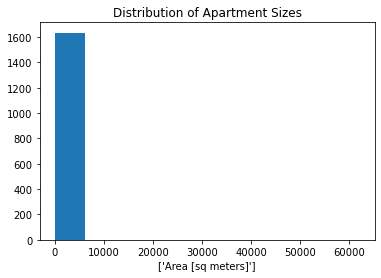

In [21]:
# Create a histogram of "surface_covered_in_m2"
plt.hist(df["surface_covered_in_m2"])
plt.xlabel(["Area [sq meters]"])
plt.title("Distribution of Apartment Sizes");

Histogram like the one above suggests that there are outliers in my dataset. In detail, I have this x-axis that's really long (all the way up to 1600 sq meters) and I can't really see anything. I know that matplotlib creates the axis automatically, there's must a value in my dataset that's really large. Looks like the vast majority of my data is on the left (0 - 500 sq meters).

**Area Summary Stastics**

In [22]:
# Calculate the summary statistics for df using the describe method
df.describe()

,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms
count,1.781000e+03,1.781000e+03,1781.000000,1247.000000,1635.000000,1198.000000,1618.000000,482.000000,1385.000000
mean,2.285410e+05,2.178037e+06,143647.215239,114.417001,97.877064,2231.534726,4340.345113,10.085062,2.434657
std,4.100189e+05,1.141710e+06,75298.758506,1755.263895,1533.057610,650.139587,8126.940810,44.783320,1.065193
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.224587,1.000000,1.000000
25%,9.000000e+04,1.349454e+06,89000.000000,40.000000,38.000000,1815.485830,1973.750000,2.000000,2.000000
50%,1.300000e+05,1.849813e+06,122000.000000,55.000000,50.000000,2151.642336,2411.239496,4.000000,2.000000
75%,1.911340e+05,2.653420e+06,175000.000000,79.000000,73.000000,2577.003583,2958.157462,7.000000,3.000000
max,5.487000e+06,6.034635e+06,398000.000000,62034.000000,62034.000000,5975.609756,57156.250000,616.000000,6.000000


In [23]:
# Look at the summary statistics for the "surface_covered_in_m2" feature
df.describe()["surface_covered_in_m2"]

count     1635.000000
mean        97.877064
std       1533.057610
min          0.000000
25%         38.000000
50%         50.000000
75%         73.000000
max      62034.000000
Name: surface_covered_in_m2, dtype: float64

 - Above doesn't make sense because you can't have an argument with an area of 0
 - I have a huge maximum value of 62034 while the mean is 97
 - This points to I have a spread out data (skewed)
 - My Standard Deviation is 1533 while the mean is around a 100. This is a really skewed data (confirming what I  saw in the histogram)
 - The statistics above confirm what I suspected. While most of the apartments in my dataset are smaller that 73 square meters, there are some that are several thousand square meters
 - I need more data cleaning and the best thing to do is to change my wrangle function and remove them from the dataset

**Remove Outliers**

In [24]:
# All observations should fall between the 0.1 and 0.9 quantiles for "surface_covered_in_m2"
df["surface_covered_in_m2"].quantile([0.1, 0.9])

0.1     31.0
0.9    100.0
Name: surface_covered_in_m2, dtype: float64

In [25]:
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
low

31.0

In [26]:
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
high

100.0

In [27]:
mask_area = df["surface_covered_in_m2"].between(low,high)
mask_area.head()

0     False
4      True
9      True
11    False
20    False
Name: surface_covered_in_m2, dtype: bool

In [28]:
# Add to wrangle function so that it removes observations that are outliers in the "surface_covered_in_m2"

def wrangle(filepath):
    # Read CSV file into DataFrame
    df = pd.read_csv(filepath)
    
    # Subset to properties in "Capital Federal"
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    
    # Subset to "apartments"
    mask_apt = df["property_type"] == "apartment"
    
    # Subset to properties where "price_aprox_usd" < 400,000
    mask_price = df["price_aprox_usd"] < 400_000
    
    # Subset
    df = df[mask_ba & mask_apt & mask_price]
    
    # Remove outliers by "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low,high)
    df = df[mask_area]
    
    return df

In [29]:
df = wrangle("data/buenos-aires-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...


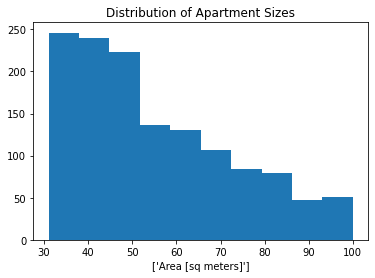

In [30]:
# Create a histogram of "surface_covered_in_m2"
plt.hist(df["surface_covered_in_m2"])
plt.xlabel(["Area [sq meters]"])
plt.title("Distribution of Apartment Sizes");

Now that my dataset is free of outliers, it's time to start exploring the relationship between apartment size and price. 

**Price vs Area Scatter Plot**

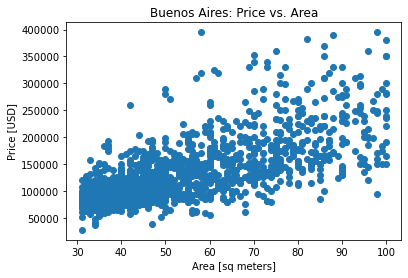

In [31]:
# Create a scatter plot that shows price ("price_aprox_usd") vs area ("surface_covered_in_m2") in my dataset
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area");

This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if the thing I want to predict is price, size will be a good feature to include.

I see a stronger correlation (clear line in the lower end) where it indicates that the area helps determine the price of an apartment.

## Split

In this part of model-building project, I will be separating my target (the thing I want to predict) from my features (the information my model will use to make its predictions). Since this is my first model, I'll use just one feature: apartment size.

**Split Data: Feature Matrix**

In [32]:
# Create the feature matrix named X_train, which I'll use to train my model
features = ["surface_covered_in_m2"] # It should contain one feature only: ["surface_covered_in_m2"]
X_train = df[features] # Feature matrix should always be two-dimensional
X_train.head()

,surface_covered_in_m2
4,70.0
9,42.0
29,54.0
40,42.0
41,50.0


Above looks like a DataFrame and not a series. So I know that if it's a DataFrame, it's a matrix.

In [33]:
X_train.shape

(1343, 1)

I have 1343 rows and 1 column. Even though there's only one column, it's still two dimensional.
Now that I have features, the next step is to create a target. 

I'm adding a _train tag to the variable names for my feature matrix and target vector. This is to remind me that this is the data I'll use to train my model, and not the data I'll use to test it.

**Split Data: Target Vector**

In [34]:
# Create the target vector named y_train, which I'll use to train my model
target = "price_aprox_usd" # Target should be "price_aprox_usd"
y_train = df[target]
y_train.head()

4     129000.0
9      87000.0
29    118000.0
40     57000.0
41     90000.0
Name: price_aprox_usd, dtype: float64

Before with features, I had a list. Now for my target, I'm just doing the string. This is important because above is a series and not a DataFrame. 

In [35]:
y_train.shape

(1343,)

I have 1343 values in it but after the commma, there is nothing. This is only one dimension and tells me it's a vector.

# Build Model

## Baseline

GOAL: Build a model that predicts the same price regardless of an apartment's size. 
 - This is a regression problem (the thing I'm trying to predict, the "target", is a continous value
 - In order to set my baseline, I need to find what is the main value for y_train
 - Baseline = Dumb Model 
 - Make the mean price the prediction

**Baseline: Calculate Mean**

In [36]:
# Calculate the mean of target vector y_train and assign it to the variable y_mean
y_mean = y_train.mean()
y_mean

135527.83871928515

Above is the mean apartment price.

Now that I have the one prediction that my dumb model will always make, I need to generate a list that repeats the prediction for every observation in my dataset.

**Baseline: Prediction List**

In [37]:
# Create a list named y_pred_baseline containing the value of y_mean repeated so it's the same length at y
y_pred_baseline = y_mean
y_pred_baseline

135527.83871928515

In [38]:
# I actually need a list so take y_mean and put it inside a list
y_pred_baseline = [y_mean]
y_pred_baseline

[135527.83871928515]

In [39]:
# Multiply it by the length of y_train
y_pred_baseline = [y_mean] * len(y_train)
len(y_pred_baseline)

1343

In [40]:
# Making sure above is the samze size as my y_train
y_pred_baseline = [y_mean] * len(y_train)
len(y_pred_baseline) == len(y_train)

True

In order to find out what my baseline model perform, I can plot it on top of the scatter plot I made above.

**Baseline: Scatter Plot**

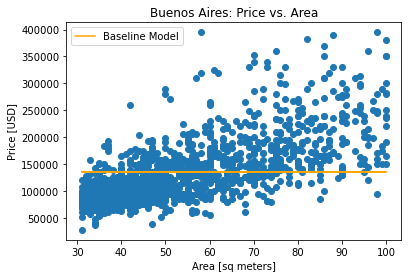

In [41]:
# Show relationship between the observations X_train and my dumb model's predictions y_pred_baseline
plt.plot(X_train, y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

As I move right to left, the area of a house increases. The size of the house increases and I can see that no matter what the size of the house, my model is always going to predict the same thing over and over again as it's my dumb model.

So graphing my prediction (my model as a function as a graph), I see a horizontal line.

Looking at this visualization, it seems like my baseline model doesn't really follow the trend in the data. So it doesn't look like it's a great fit. But, one can't depend only on a subjective plot to evaluate a model. 

I need an exact (mathematically calculate **performance metric**). There are lots of performance metrics, but the one I'll use here is the **mean absolute error**.  

**Baseline: Mean Absolute Error**

In [42]:
# Calculate the baseline mean absolute error for predictions in y_pred_baseline as compared to the true targets in y

mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price: 135527.84
Baseline MAE: 45199.46


The information above tells me that if I always predicted that an apartment price is \\$135,527.84, my predictions would be off by an average of $45,199.46. 

It also tells me that my model needs to have mean absolute error below \\$45,199.46 in order to be useful. 

## Iterate

Iterating involves building a model, training it, evaluating it, and then repeating the process until I'm happy with my model's performance. 

Even though the model I'm building is linear, the iteration process rarely follows a straight line.

The first thing I need to do is create my model — in this case, one that uses linear regression.

**Instantiate Model**

In [43]:
# Instantiate a LinearRegression model named model
model = LinearRegression()

The second thing I need to do is use my data to train my model. Another way to say this is fit my model to the training data.

**Train Model**

In [44]:
# Fit my model to the data, X_train and y_train
model.fit(X_train, y_train)

LinearRegression()

In [45]:
# Checking my work
check_is_fitted(model)

## Evaluate

The final step is to evaluate my model. In order to do that, I'll start by seeing how well it performs when making predictions for data that it saw during training. So I'll have it predict the price for the houses in my training set.

**Generate Predictions**

In [46]:
# Use model's predict method to create a list of predictions for the observations in feature matrix X_train
y_pred_training = model.predict(X_train)  # Name this array y_pred_training.
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

Now that I have predictions, I'll use them to assess my model's performance with the training data. I'll use the same metric I used to evaluate my baseline model: mean absolute error.

**Training Mean Absolute Error**

In [47]:
# Calculate training mean absolute error for predictions in y_pred_training 
mae_training = mean_absolute_error(y_train, y_pred_training) # As compared to the true targets in y_train
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26


My model beat the baseline by over $10,000. That's a good indicator that it will be helpful in predicting apartment prices. But the real test is how the model performs on data that it hasn't seen before, data that we call the test set.

In [48]:
# Import test data buenos-aires-test-features.csv into a DataFrame
X_test = pd.read_csv("data/buenos-aires-test-features.csv")[features]

# Generate a Series of predictions using the model
y_pred_test = pd.Series(model.predict(X_test)) # Make sure the X_train is same column order as X_test
y_pred_test.head()

0    117330.058901
1    135355.037823
2     88039.468152
3     88039.468152
4    106064.447074
dtype: float64

Ideally, I want my test performance metrics to be the same as its training performance metrics. In practice, test metrics tend to be a little worse (this means a larger number in the case of mean absolute error). But as long as the training and test performance are close to each other, I can be confident that my model will generalize well. 

During the iteration phase, I can change and retrain my model as many times as I want. I can also check the model's training performance repeatedly. But once I evaluate its test performance, I can't make any more changes. 
    
A test only counts if neither the model nor I has seen the data before. If I check my test metrics and then make changes to the model, I can introduce biases into the model that compromise its generalizability. 

# Communicate Results

<center><img src="images/proj-2.003.png" alt="Equation: y = m*x + b" style="width: 400px;"/></center>
<center><img src="images/proj-2.004.png" alt="Equation: y = beta 0 + beta 1 * x" style="width: 400px;"/></center>
I need to find the values that my model has determined for the intercept and and coefficient. Fortunately, all trained models in scikit-learn store this information in the model itself.

**Extract Model Intercept**

In [49]:
# Extract the intercept from the model, and assign it to the variable intercept
intercept = round(model.intercept_, 2) # Round it to two decimal points
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 11433.31


Next comes the coefficient. I'll extract it in a very similar way.

**Extract Model Coefficient**

In [50]:
# Extract the coefficient associated "surface_covered_in_m2" in my model
coefficient = round(model.coef_[0], 2) # Assign it to the variable `coefficient`
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model coefficient for "surface_covered_in_m2": 2253.12


I know that for every square meter I add to an apartment, my model predicts an additional $2253 in sale price.

Now that I have my intercept and coefficient, I need to insert them into a string that I can print out the complete equation.

**Generate Equation**

In [51]:
# Print the equation that the model has determined for predicting apartment price based on size
print(f"apt_price = {intercept} + {coefficient} * surface_covered") # F string allows me to print out character values like "apt_price" and also insert variable names

apt_price = 11433.31 + 2253.12 * surface_covered


Above is the equation for my model. So this is **y = apt_price, Beta(0) = 11433.31, Beta(1) = 2253.12, surface_covered = X (area)** .

**Plot Model**

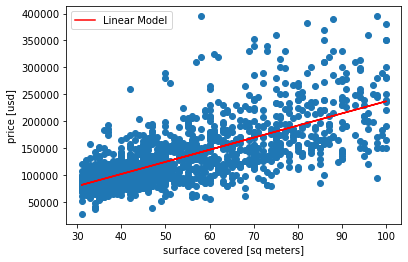

In [52]:
# Plot the relationship between the observations in X_train and my model's predictions y_pred_training
plt.plot(X_train, model.predict(X_train), color="r", label="Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();